In [1]:
from IPython import get_ipython
from IPython.display import display

In [2]:
!pip install tensorflow
!pip install keras
!pip install kaggle
!pip install opencv-python

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import kagglehub
from kagglehub import KaggleDatasetAdapter
from google.colab import files
import os
import pathlib
import cv2

In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/CollabData/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

cp: cannot stat '/content/drive/MyDrive/CollabData/kaggle_API/kaggle.json': No such file or directory


In [6]:
! chmod 600 ~/.kaggle/kaggle.json

chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [7]:
! kaggle datasets download cakrulgaming/indonesia-traffic-sign

Dataset URL: https://www.kaggle.com/datasets/cakrulgaming/indonesia-traffic-sign
License(s): unknown
 99% 89.0M/89.9M [00:00<00:00, 193MB/s]
100% 89.9M/89.9M [00:00<00:00, 174MB/s]


In [8]:
! unzip indonesia-traffic-sign.zip

Archive:  indonesia-traffic-sign.zip
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (100).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (100).txt  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (71).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (71).txt  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (72).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (72).txt  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (73).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (73).txt  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (74).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (74).txt  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (75).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (75).txt  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (76).jpg  
  inflating: traffic_sign/test/lampu-hijau/lampu hijau (76).txt  
  inflating: traffic_sign/test/lampu-

In [9]:
def detect_lines(image_path):
    """Detects lines in an image using the Hough Line Transform.
    Args:
        image_path: Path to the input image.
    Returns:
        An image with detected lines overlaid.
    """
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLines(edges, 1, np.pi/180, 200)

    if lines is not None:  # Check if any lines were detected
        for line in lines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a*rho
            y0 = b*rho
            x1 = int(x0 + 1000*(-b))
            y1 = int(y0 + 1000*(a))
            x2 = int(x0 - 1000*(-b))
            y2 = int(y0 - 1000*(a))
            cv2.line(img, (x1, y1), (x2, y2), (0, 0, 255), 2)

    return img  # Return the image with lines overlaid

In [10]:
# Create an ImageDataGenerator for preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

# Load and preprocess the training and testing datasets
train_generator = train_datagen.flow_from_directory(
    '/content/traffic_sign/train',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = test_datagen.flow_from_directory(
    '/content/traffic_sign/test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 1470 images belonging to 21 classes.
Found 630 images belonging to 21 classes.


In [11]:
# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Determine the number of classes (sports ball types) in your dataset
num_classes = 21

# Add a new classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(num_classes, activation='softmax')(x) # num_classes is now defined

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 106s 2s/step - accuracy: 0.1718 - loss: 2.8717 - val_accuracy: 0.4391 - val_loss: 1.8536
Epoch 2/10
 1/45 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.6562 - loss: 1.3705

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


45/45 ━━━━━━━━━━━━━━━━━━━━ 26s 570ms/step - accuracy: 0.6562 - loss: 1.3705 - val_accuracy: 0.4441 - val_loss: 1.8513
Epoch 3/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6418 - loss: 1.2753 - val_accuracy: 0.5592 - val_loss: 1.4825
Epoch 4/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 41s 908ms/step - accuracy: 0.6875 - loss: 1.0827 - val_accuracy: 0.5543 - val_loss: 1.4944
Epoch 5/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 142s 3s/step - accuracy: 0.7704 - loss: 0.8504 - val_accuracy: 0.5839 - val_loss: 1.3559
Epoch 6/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 34s 737ms/step - accuracy: 0.7500 - loss: 0.9060 - val_accuracy: 0.5888 - val_loss: 1.3372
Epoch 7/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 130s 2s/step - accuracy: 0.8325 - loss: 0.6757 - val_accuracy: 0.6464 - val_loss: 1.2236
Epoch 8/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 29s 625ms/step - accuracy: 0.6562 - loss: 0.9105 - val_accuracy: 0.6382 - val_loss: 1.2370
Epoch 9/10
45/45 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.8613 - loss: 0.5640 - val_accuracy: 0.6234 - val_l

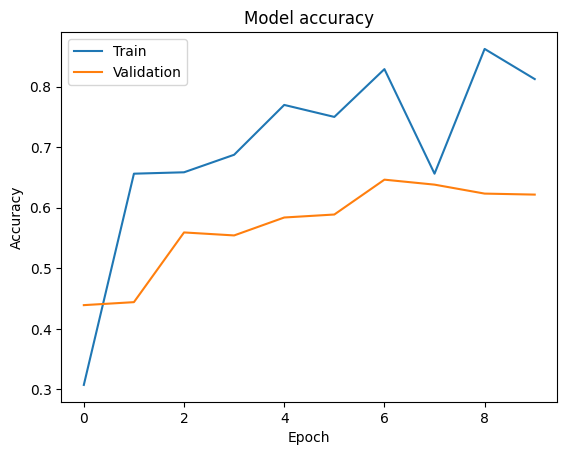

In [13]:
# Plot training accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Save the model
model.save('sports_ball_classifier.h5')

In [14]:
def predict_image(img_path, class_names):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.

    img_with_lines = detect_lines(img_path) # Add line detection

    # Convert 'img_with_lines' to RGB if needed:
    img_with_lines_rgb = cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB)

    # Continue with your existing prediction process:
    img = image.img_to_array(img_with_lines_rgb)

    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction)

    # Map predicted_class_index to the corresponding sports ball type
    predicted_class_name = class_names[predicted_class_index]

    return predicted_class_name  # Return the class name

In [15]:
class_names = list(train_generator.class_indices.keys())

In [16]:
    uploaded = files.upload()

    for fn in uploaded.keys():
      # predicting images
      path = fn
      img = image.load_img(path, target_size=(224,224))
      predicted_class_name = predict_image(path, class_names) # Call the function here
      print(f"The predicted class for {fn} is: {predicted_class_name}")

KeyboardInterrupt: 